In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd
import re
import cv2

In [36]:
def collect_image_info(dataset_root):
    data = []

    for label in ["CME", "Non-CME"]:
        label_path = os.path.join(dataset_root, label)

        if not os.path.isdir(label_path):
            continue

        for patient_folder in os.listdir(label_path):
            patient_path = os.path.join(label_path, patient_folder)

            if not os.path.isdir(patient_path):
                continue

            for image_name in os.listdir(patient_path):
                if image_name.lower().endswith('.png'):
                    image_name_lower = image_name.lower()
                    eye = None

                    # Match exact OD or OS as separate tokens
                    if re.search(r'\bod\b', image_name_lower):
                        # print(f"right: {image_name}")
                        eye = 'right'
                    elif re.search(r'\bos\b', image_name_lower):
                        # print(f"left: {image_name}")
                        eye = 'left'
                    else:
                        print(f"eye not found: {image_name}")

                    full_path = os.path.join(patient_path, image_name)

                    data.append({
                        "class": label,
                        "patient_id": patient_folder,
                        "eye": eye,
                        "image_path": full_path
                    })

    df = pd.DataFrame(data)
    return df

In [37]:
dataset_root = "/data2/users/koushani/chbmit/Eye_ML/data/RV_images_cropped"

In [38]:
df = collect_image_info(dataset_root)

In [39]:
print(df.tail(10))

      class patient_id    eye  \
55  Non-CME      CL OU   left   
56  Non-CME      CL OU  right   
57  Non-CME    JanC OD  right   
58  Non-CME    MicC OU   left   
59  Non-CME    MicC OU  right   
60  Non-CME    RogD OD  right   
61  Non-CME    ZarD OU   left   
62  Non-CME    ZarD OU  right   
63  Non-CME    PauB OU   left   
64  Non-CME    PauB OU  right   

                                           image_path  
55  /data2/users/koushani/chbmit/Eye_ML/data/RV_im...  
56  /data2/users/koushani/chbmit/Eye_ML/data/RV_im...  
57  /data2/users/koushani/chbmit/Eye_ML/data/RV_im...  
58  /data2/users/koushani/chbmit/Eye_ML/data/RV_im...  
59  /data2/users/koushani/chbmit/Eye_ML/data/RV_im...  
60  /data2/users/koushani/chbmit/Eye_ML/data/RV_im...  
61  /data2/users/koushani/chbmit/Eye_ML/data/RV_im...  
62  /data2/users/koushani/chbmit/Eye_ML/data/RV_im...  
63  /data2/users/koushani/chbmit/Eye_ML/data/RV_im...  
64  /data2/users/koushani/chbmit/Eye_ML/data/RV_im...  


In [40]:
def compute_image_stats(df):
    stats = []

    for _, row in df.iterrows():
        img_path = row["image_path"]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale

        if img is None:
            continue

        h, w = img.shape
        mean_intensity = img.mean()
        std_intensity = img.std()
        min_val = img.min()
        max_val = img.max()

        stats.append({
            "class": row["class"],
            "patient_id": row["patient_id"],
            "eye": row["eye"],
            "image_path": img_path,
            "height": h,
            "width": w,
            "mean_intensity": mean_intensity,
            "std_intensity": std_intensity,
            "min_val": min_val,
            "max_val": max_val
        })

    stats_df = pd.DataFrame(stats)
    return stats_df

In [41]:
stats_df = compute_image_stats(df)

In [42]:
# Basic summaries
print(stats_df.describe())

            height        width  mean_intensity  std_intensity  min_val  \
count    65.000000    65.000000       65.000000      65.000000     65.0   
mean    855.353846   857.107692       51.265301      38.373872      0.0   
std     253.308571   253.774452       15.037393       7.521898      0.0   
min     754.000000   758.000000       23.258173      26.721086      0.0   
25%     760.000000   762.000000       41.369882      33.711151      0.0   
50%     762.000000   763.000000       46.674504      37.161092      0.0   
75%     764.000000   765.000000       59.550287      40.972291      0.0   
max    1529.000000  1530.000000      107.041443      70.665523      0.0   

         max_val  
count  65.000000  
mean   -1.061538  
std     0.496139  
min    -5.000000  
25%    -1.000000  
50%    -1.000000  
75%    -1.000000  
max    -1.000000  


In [43]:
# Check resolution distribution
print(stats_df.groupby(['height', 'width']).size())

height  width
754     765      1
755     765      1
756     759      1
758     763      1
759     758      1
        759      1
        761      1
        762      1
        766      1
760     759      1
        760      4
        761      3
        762      4
        763      2
        764      1
        765      2
761     762      2
        764      1
        765      1
        766      1
762     761      1
        762      5
        763      1
        764      2
        765      1
763     761      1
        762      1
        763      2
        765      2
764     763      1
        764      2
        765      1
        766      1
765     763      1
        765      2
        766      1
767     764      1
1522    1528     1
1524    1529     2
1526    1530     1
1527    1530     1
1529    1528     1
        1530     2
dtype: int64


In [44]:
# Class balance
print(stats_df['class'].value_counts())

CME        35
Non-CME    30
Name: class, dtype: int64


In [45]:
# Eye balance
print(stats_df['eye'].value_counts())

left     33
right    32
Name: eye, dtype: int64


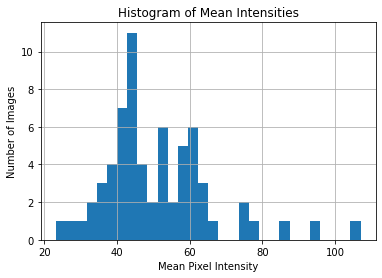

In [46]:

plt.hist(stats_df["mean_intensity"], bins=30)
plt.title("Histogram of Mean Intensities")
plt.xlabel("Mean Pixel Intensity")
plt.ylabel("Number of Images")
plt.grid(True)
plt.show()

In [47]:

def central_crop(img, crop_size=256):
    h, w = img.shape[:2]
    cx, cy = w // 2, h // 2
    x1 = max(cx - crop_size // 2, 0)
    y1 = max(cy - crop_size // 2, 0)
    x2 = x1 + crop_size
    y2 = y1 + crop_size
    return img[y1:y2, x1:x2]

In [53]:
def show_with_guiding_box_and_crop(image_path, guide_x=120, guide_y=100, box_size=300):
    img = cv2.imread(image_path)
    clone = img.copy()

    # Draw guiding rectangle
    cv2.rectangle(clone, (guide_x, guide_y), (guide_x + box_size, guide_y + box_size), (0, 0, 255), 2)
    cv2.imshow("Guiding Box - Press 's' to start manual crop", clone)
    key = cv2.waitKey(0)
    if key == ord('s'):
        roi = cv2.selectROI("Manual Crop", img, showCrosshair=True)
        cv2.destroyAllWindows()
        x, y, w, h = roi
        cropped = img[y:y+h, x:x+w]
        return cropped
    cv2.destroyAllWindows()
    return None

In [54]:
output_cropped_root = "/data2/users/koushani/chbmit/Eye_ML/data/macular_cropped_dataset"
crop_size = 256

In [55]:
cropped_img = show_with_guiding_box_and_crop("/data2/users/koushani/chbmit/Eye_ML/data/RV_images_cropped/CME/ACB_OU/ACB OD close.png")
if cropped_img is not None:
    cv2.imwrite("manual_cropped.png", cropped_img)

error: OpenCV(4.10.0) /io/opencv/modules/highgui/src/window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'
